In [16]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!pip install jitcdde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jitcdde: filename=jitcdde-1.8.1-py3-none-any.whl size=55003 sha256=0380bb769087f24f5845166a7ff972e1cec89aeea9a9bb9e6facf4e81b98591c
  Stored in directory: /root/.cache/pip/wheels/42/e3/4e/94b61188e5e3e62ba27e9586da5ecc7ea0f24e26916a250cc7
  Created wheel for chspy: filename=CHSPy-1.2.2-py3-none-any.whl size=11999 sha256=6924ba9f9261391ea31c426d6bf0c8af5fa74e36977f8b6dbbb80684f69d05ff
  Stored in directory: /root/.cache/pip/wheels/11/17/24/0cca70842afd051f54325b813e637d8e8836d88c286ba63fae
  Created wheel for jitcxde_common: filename=jitcxde_common-1.5.4-py3-none-any.whl size=16755 sha256=59b5e29c06cd22416018eebdf2d0538702c3ffdb0e063d8df6bcd0d37ed5c990
  Stored in directory: /root/.cach

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jitcdde import jitcdde, y, t
from numpy import pi, arange, random, max
import symengine
from scipy.signal import welch
from tqdm import tqdm
import os

import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

In [4]:
def load_node_categories(filepath):
    node_data = pd.read_csv(filepath)
    node_data['Node'] = node_data['Node'] - 1
    node_groups = node_data.groupby('Super_Region')['Node'].apply(list).to_dict()
    return node_groups

In [5]:
weight_filename = "gdrive/MyDrive/PBM-report2/WeightedA33.dat"
mapping_filename = "gdrive/MyDrive/PBM-report2/Y_Categorized_Brain_Nodes.csv"
fiber_length_filename = "gdrive/MyDrive/PBM-report2/LengthFibers33.dat"

w_kj = np.loadtxt(weight_filename)
num_nodes = w_kj.shape[0]

node_groups = load_node_categories(mapping_filename)
# node_groups

<ipython-input-49-30a91c7bea9c>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(node_groups)).colors
<ipython-input-49-30a91c7bea9c>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  region_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=region_cmap), ticks=range(len(sorted_regions)),


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (7).

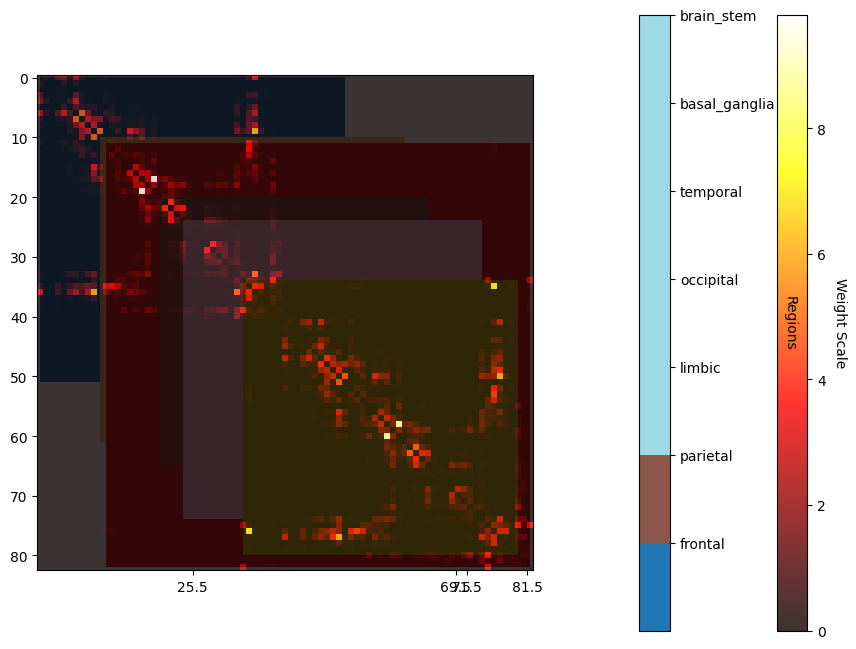

In [ ]:
# Create a list of colors for the regions
colors = plt.cm.get_cmap('tab20', len(node_groups)).colors

# Creating a new colormap for the regions based on the tab20 colormap
from matplotlib.colors import ListedColormap
region_cmap = ListedColormap(colors[:len(node_groups)])

# Define region boundaries
region_boundaries = {region: (min(nodes), max(nodes)+1) for region, nodes in node_groups.items()}

# Sort regions by their starting index
sorted_regions = sorted(region_boundaries.items(), key=lambda item: item[1][0])

# Create ticks for the heatmap
ticks = [0] + [boundary[1] for region, boundary in sorted_regions]
tick_labels = [region for region, boundary in sorted_regions]

# Assign colors to regions
region_colors = np.zeros((len(w_kj), len(w_kj), 4))
for i, ((region, (start, end)), color) in enumerate(zip(sorted_regions, colors)):
    region_colors[start:end, start:end] = color

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(region_colors, extent=[0, len(w_kj), len(w_kj), 0])
im = plt.imshow(w_kj, cmap='hot', interpolation='nearest', alpha=0.8)

# Adding the color bar for weights
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Weight Scale', rotation=270, labelpad=15)

# Adding the color bar for regions
region_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=region_cmap), ticks=range(len(sorted_regions)),
                          boundaries=range(-1, len(sorted_regions)), orientation='vertical', pad=0.15)
region_bar.set_ticklabels(tick_labels)
region_bar.set_label('Regions', rotation=270, labelpad=15)

# Adding the labels
plt.xticks(ticks=np.mean(np.array(ticks).reshape(-1, 2), axis=1), labels=tick_labels, rotation=90)
plt.yticks(ticks=np.mean(np.array(ticks).reshape(-1, 2), axis=1), labels=tick_labels)

# Adding minor ticks to create the grid
plt.setp(plt.gca(), xticks=ticks[:-1], yticks=ticks[:-1], xticklabels=[], yticklabels=[])
plt.gca().tick_params(which="minor", size=0)

# Add the title
plt.title('Heatmap of Node Connection Strengths with Region Mapping')

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# Define the differential equation model
def dcdt(c_k, q_k, w_kj, alpha):
    # Define the graph Laplacian matrix L
    D = np.diag(w_kj.sum(axis=1))
    L = rho * (D - w_kj)
    return -L.dot(c_k) + alpha * c_k * (1 - c_k)

def dqdt(c_k, q_k, beta):
    return beta * c_k * (1 - q_k)

def dwdt(w_kj, q_k, gamma):
    q_sum = q_k[:, None] + q_k  # Calculate the sum of damage
    return -gamma * w_kj * q_sum

# Integrate the model equations
def model(y, t, beta, gamma):
    num_variables = 2 * num_nodes + num_nodes**2
    c_k = y[:num_nodes]
    q_k = y[num_nodes:2*num_nodes]
    w_kj = y[2*num_nodes:num_variables].reshape((num_nodes, num_nodes))

    # Calculate dc/dt, dq/dt, dw/dt
    dc_dt = dcdt(c_k, q_k, w_kj, alpha)
    dq_dt = dqdt(c_k, q_k, beta)
    dw_dt = dwdt(w_kj, q_k, gamma).flatten()

    # Merge them back into a flat array
    dydt = np.concatenate((dc_dt, dq_dt, dw_dt))
    return dydt

In [7]:
# Initialize c_k (toxic protein concentration), q_k (node damage), and w_kj (edge weight)
c_k = np.zeros(num_nodes)
q_k = np.zeros(num_nodes)

seed_protein_concentration = 0.025

# Define model parameters
alpha = 0.75  # 3/4 per year
beta_severe = 1 / 4
gamma_severe = 1 / 8
rho = 1 / 100  # mm/yr, Laplacian rate constant

# Assume that the node indexes corresponding to the medial frontal area are 26 and 68
entorhinal_nodes = [26, 68]
for entorhinal_node in entorhinal_nodes:
    c_k[entorhinal_node-1] = seed_protein_concentration

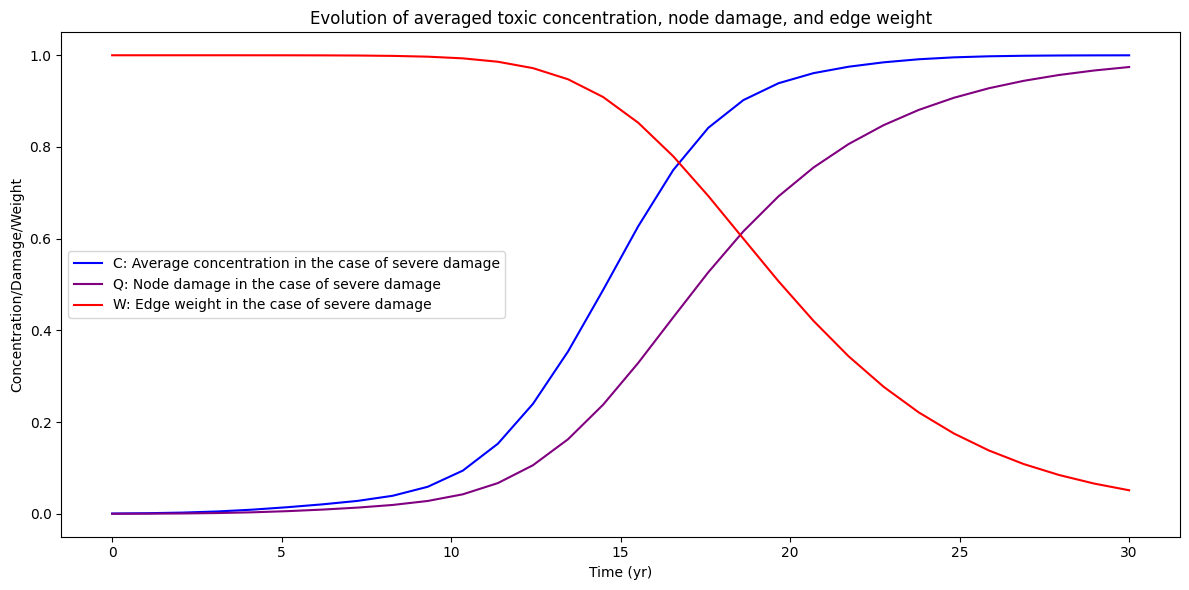

In [8]:
np.random.seed(42)
# Set the time points
transport_times = np.linspace(0, 30, 30) # From 0 to 30 years, a total of 1000 time points

# Set initial conditions
y0 = np.concatenate((c_k, q_k, w_kj.flatten()))

# Severe damage (β=1/4, γ=1/8)
sol_severe = odeint(model, y0, transport_times, args=(beta_severe, gamma_severe))
c_k_severe = sol_severe[:, :num_nodes]
q_k_severe = sol_severe[:, num_nodes:2*num_nodes]
w_kj_severe = sol_severe[:, 2*num_nodes:].reshape((len(transport_times), num_nodes, num_nodes))
C_T_severe = c_k_severe.mean(axis=1)
Q_severe = q_k_severe.mean(axis=1)
W_severe = np.array([np.linalg.norm(w) / np.linalg.norm(w_kj) for w in w_kj_severe])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(transport_times, C_T_severe, 'b-', label='C: Average concentration in the case of severe damage')
plt.plot(transport_times, Q_severe, color="purple", label='Q: Node damage in the case of severe damage')
plt.plot(transport_times, W_severe, 'r-', label='W: Edge weight in the case of severe damage')
plt.title('Evolution of averaged toxic concentration, node damage, and edge weight')
plt.xlabel('Time (yr)')
plt.ylabel('Concentration/Damage/Weight')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
df_fiber_length = np.loadtxt(fiber_length_filename)
tau_kj = df_fiber_length/1500

# We flatten the array for the qcut function and then reshape it back to the original shape.
discretized_data, bins = pd.qcut(tau_kj.ravel(), 40, retbins=True, labels=False, duplicates='drop')

# Calculate the mean of the bins
bin_means = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map discretized data to the mean of the interval
discretized_tau_kj = np.array([bin_means[i] for i in discretized_data])
discretized_tau_kj = discretized_tau_kj.reshape(tau_kj.shape)

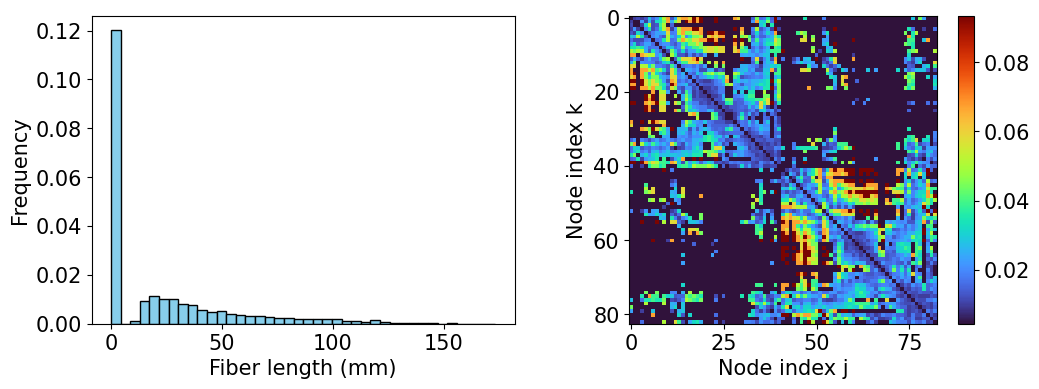

In [17]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot the distribution of delays, excluding zero
axes[0].hist(df_fiber_length.ravel(), bins=40, density=True, color='skyblue', edgecolor='black')
# axes[0].set_title('Distribution of Fiber length')
axes[0].set_xlabel('Fiber length (mm)', fontsize=15)
axes[0].set_ylabel('Frequency', fontsize=15)

# Plotting the heatmap
heatmap = axes[1].imshow(discretized_tau_kj, cmap='turbo')
plt.colorbar(heatmap, ax=axes[1])
# axes[1].set_title('Heatmap of weight matrix tau_kj')
axes[1].set_xlabel('Node index j', fontsize=15)
axes[1].set_ylabel('Node index k', fontsize=15)

# plt.tight_layout()
# Show the figure
plt.show()

In [13]:
def sigmoid(x):
    return 1 / (1 + symengine.exp(-x))

def compute_metrics(excitatory, inhibitory, dt, omega, nperseg=None):
    """
    Compute the metrics for the provided excitatory and inhibitory signals.

    Parameters:
    excitatory (np.array): Array of excitatory signals with shape (time_steps, num_nodes)
    inhibitory (np.array): Array of inhibitory signals with shape (time_steps, num_nodes)
    fs (float): Sampling frequency of the signals.
    nperseg (int): Length of each segment for Welch's method.

    Returns:
    tuple: Tuple containing the power P(T), average oscillatory activity A(T), metastability index B(T)
    """
    fs = 1/dt
    # Combine excitatory and inhibitory signals into a complex signal z
    z = excitatory + 1j * inhibitory

    # Compute the mean signal across all nodes (average order parameter)
    avg_z = np.mean(z, axis=1)

    # Calculate Power Spectral Density of the mean signal using Welch's method
    f, psd = welch(avg_z, fs=fs, nperseg=nperseg)

    # Integrate the PSD over the frequency range Gamma (you'll need to define this range)
    # Assuming Gamma is the entire frequency range for this example
    # For a specific range, you would restrict the integration to the indices corresponding to that frequency range
    # Filter out negative frequencies and sort them
    omega = np.sort(omega[omega >= 0])

    # Interpolate PSD to the sampled frequencies
    interpolated_psd = np.interp(omega, f, psd)

    # Integrate the PSD over the sampled frequencies
    P_T = np.trapz(interpolated_psd, omega)

    # Compute A(T) and B(T) as before
    A_T = np.mean(np.trapz(np.abs(z), dx=1/fs, axis=0))
    B_T = np.mean(np.var(np.abs(z), axis=0))

    # print(f"P_T:{P_T}, A_T:{A_T}, B_T:{B_T}")

    return P_T, A_T, B_T

In [14]:
def rsd_model(w_kj):
  n = num_nodes
  mean_omega = 40
  variance_omega = 0.1
  ω = np.random.normal(mean_omega, np.sqrt(variance_omega), n)
  c = 42
  λ = -0.01
  A = w_kj
  τ = discretized_tau_kj
  k = 10

  def resting_state_model():
    for i in range(num_nodes):
      # calculate the coupling sum for excitatory population
      coupling_sum = sum( A[i,j]*y(2*j, t-τ[i,j]) for j in range(num_nodes) )
      # apply the sigmoid functuon to the coupling term
      coupling_term = sigmoid(coupling_sum)

      # Excitatory population equation
      yield λ * y(2*i) - ω[i]*y(2*i+1) - y(2*i) * (y(2*i)**2 + y(2*i+1)**2) + k*coupling_term

      # Inhibitory population equation
      yield λ * y(2*i+1) + ω[i]*y(2*i) - y(2*i+1) * (y(2*i)**2 + y(2*i+1)**2)

  I = jitcdde(resting_state_model,n=2*n,verbose=False,delays=τ.flatten())
  I.set_integration_parameters(rtol=0,atol=1e-5)

  I.constant_past( np.random.rand(n*2), time=0.0 )
  I.integrate_blindly( max(τ) , 0.01 )

  # Time span for integration (10 seconds)
  t_end = 12
  dt = 0.01  # Adjust dt to the desired time resolution
  times = np.arange(2, t_end, dt)
  data = np.zeros((len(times), n*2))  # Pre-allocate space for efficiency

  # for time in I.t + arange(0,10,0.01):
  #   print(I.integrate(time))

  # Integrate and store the data
  for i, time in enumerate(times):
      data[i] = I.integrate(time)

  exc = data[:,:83]
  inh = data[:,83:]
  return exc, inh, dt, times, ω

In [15]:
exc, inh, dt, times, omega = rsd_model(w_kj)

In [ ]:
exc

array([[-0.56790357,  1.30578789, -0.71021532, ..., -0.6044529 ,
         1.29625499, -0.36790563],
       [-0.9707669 ,  0.97422731, -0.97956982, ..., -1.00812542,
         0.95007748, -0.80179868],
       [-1.24885137,  0.5103815 , -1.10496208, ..., -1.26540922,
         0.47931451, -1.15984434],
       ...,
       [-1.31428372,  0.23031156, -1.08499419, ..., -1.31652234,
        -0.03663202, -1.19625754],
       [-1.27762802, -0.29407625, -0.9531591 , ..., -1.17871064,
        -0.53325862, -1.35374151],
       [-1.04456719, -0.75513722, -0.67965614, ..., -0.86569641,
        -0.93172594, -1.29865917]])

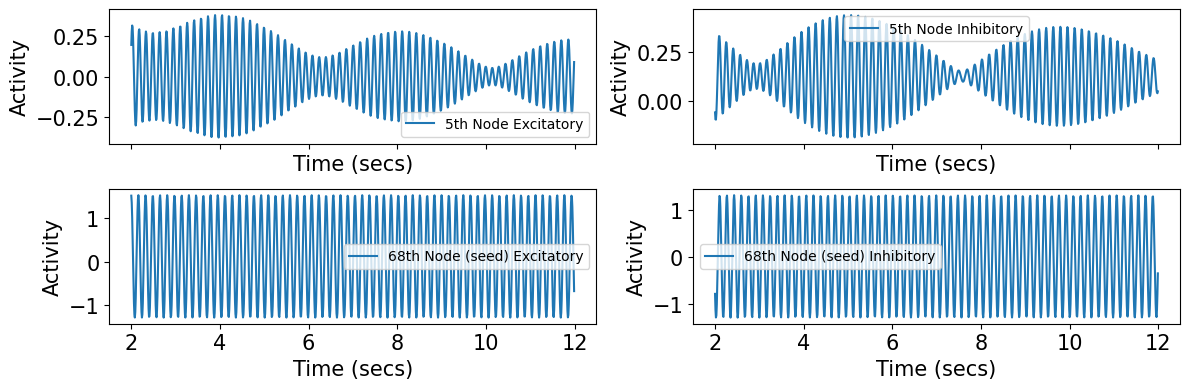

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4), sharex=True)
indices = [4, 67]

# Define a function to plot the data efficiently
def plot_data(ax, times, data, node_idx, title, label):
    ax.plot(times, data[:, node_idx], label=label)
    # ax.set_title(title)
    ax.set_xlabel('Time (secs)', fontsize=15)
    ax.set_ylabel('Activity', fontsize=15)
    ax.legend()

# Plot the excitatory and inhibitory data for the 5th node
plot_data(axs[0, 0], times, exc, 4, '5th Node Excitatory Activity', '5th Node Excitatory')
plot_data(axs[0, 1], times, inh, 4, '5th Node Inhibitory Activity', '5th Node Inhibitory')

# Plot the excitatory and inhibitory data for the 68th node
plot_data(axs[1, 0], times, exc, 67, '68th Node Excitatory Activity', '68th Node (seed) Excitatory')
plot_data(axs[1, 1], times, inh, 67, '68th Node Inhibitory Activity', '68th Node (seed) Inhibitory')

plt.tight_layout()
plt.show()

# Plot the results with coupling
# plt.figure(figsize=(12, 6))

# plt.subplot(2, 1, 1)
# plt.plot(times, exc[:,70], label='Excitatory Amplitude with Coupling for node 5')
# plt.xlabel('Time')
# plt.ylabel('X Amplitude')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(times, inh[:,70], label='Inhibitory Amplitude with Coupling for node 5')
# plt.xlabel('Time')
# plt.ylabel('Y Amplitude')
# plt.legend()

# plt.tight_layout()
# plt.show()

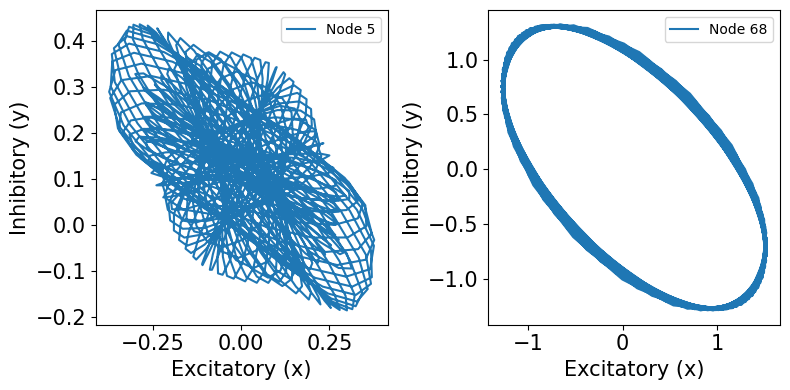

In [29]:
# Given indices
indices = [4, 67]

# Create subplots
fig, axs = plt.subplots(1, len(indices), figsize=(8, 4))

for i, index in enumerate(indices):
    axs[i].plot(exc[:, index], inh[:, index], label=f'Node {index+1}')
    axs[i].set_xlabel('Excitatory (x)', fontsize=15)
    axs[i].set_ylabel('Inhibitory (y)', fontsize=15)
    # axs[i].set_title(f'Phase Plot for Node {index+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
def normalize_biomarkers(all_realizations):
  # Normalize PT values
  for realization in all_realizations:
      normalization_factor = realization[0]
      # Make sure not to divide by zero
      if normalization_factor != 0:
          for i in range(len(realization)):
              realization[i] /= normalization_factor
  return all_realizations

# Function to calculate statistics of the metrics across realizations
def calculate_statistics(metrics_all_realizations):
    means = np.mean(metrics_all_realizations, axis=0)
    stds = np.std(metrics_all_realizations, axis=0)
    return means, stds

# Function to plot the statistics for PT, AT, BT
def plot_statistics(metrics_mean, metrics_std, title):
    # time = np.arange(len(metrics_mean))
    plt.errorbar(transport_times, metrics_mean, yerr=metrics_std, fmt='-o')
    plt.xlabel('Realization')
    plt.ylabel('Metric Value')
    plt.title(title)
    plt.grid(True)

def run_simulation(w_kj_severe, realization_index, save_path='gdrive/MyDrive/PBM-report2'):
    pt, at, bt = [], [], []
    for w in tqdm(w_kj_severe, desc=f"Realization {realization_index}"):
        exc, inh, dt, times, omega = rsd_model(w)
        PT, AT, BT = compute_metrics(exc, inh, dt, omega)
        pt.append(PT)
        at.append(AT)
        bt.append(BT)

    # Save the metrics for the current realization
    biomarkers = np.array([pt, at, bt])
    np.save(os.path.join(save_path, f'dynamic_biomarkers_realization_{realization_index}.npy'), biomarkers)

    return pt, at, bt

In [ ]:
# Main loop to run simulation for each realization and compute metrics
all_pt, all_at, all_bt = [], [], []
num_realizations = 2

for realization in tqdm(range(num_realizations), desc='Running simulations'):  # Assuming 12 realizations
    pt, at, bt = run_simulation(w_kj_severe, realization)
    all_pt.append(pt)
    all_at.append(at)
    all_bt.append(bt)

# Calculate statistics for each metric
pt_mean, pt_std = calculate_statistics(all_pt)
at_mean, at_std = calculate_statistics(all_at)
bt_mean, bt_std = calculate_statistics(all_bt)

Realization 0:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '

Running simulations: 100%|██████████| 2/2 [18:37<00:00, 558.58s/it]


### Loading the saved realizations

In [ ]:
# file_name = f'dynamic_biomarkers_realization_0.npy'
# file_path = os.path.join(save_path, file_name)
# biomarker = np.load(file_path)
# biomarker

array([[1.40809563e-04, 1.30600249e-04, 1.04592295e-04, 1.24375012e-04,
        9.31472360e-05, 1.44887959e-04, 1.19627783e-04, 1.55719566e-04,
        1.42722907e-04, 1.00392696e-04, 1.15266158e-04, 1.07784739e-04,
        9.33062955e-05, 8.18704236e-05, 5.85090529e-05, 4.29604613e-05,
        1.61703470e-05, 1.16236059e-05, 2.60071993e-07, 1.08119485e-06],
       [1.21311714e+01, 1.23617178e+01, 1.25145371e+01, 1.26478393e+01,
        1.20787078e+01, 1.25433996e+01, 1.24360480e+01, 1.24188575e+01,
        1.23059680e+01, 1.23058256e+01, 1.22573645e+01, 1.19395289e+01,
        1.15664005e+01, 1.12635872e+01, 1.05793817e+01, 9.51044458e+00,
        8.83198198e+00, 7.37872356e+00, 6.22774995e+00, 5.16479203e+00],
       [1.10697285e-01, 9.54386214e-02, 3.88927270e-02, 2.78430677e-02,
        1.47630585e-01, 3.55955382e-02, 3.32327494e-02, 2.91010997e-02,
        5.19283780e-02, 3.07723127e-02, 3.40825531e-02, 4.25072123e-02,
        9.25853950e-02, 5.37156486e-02, 6.50805236e-02, 7.3244

In [ ]:
def load_biomarkers(save_path, num_realizations):
    # Initialize lists to collect biomarkers across all realizations
    all_pt, all_at, all_bt = [], [], []

    # Load the biomarkers for each realization
    for realization_index in range(num_realizations):
        file_name = f'dynamic_biomarkers_realization_{realization_index}.npy'
        file_path = os.path.join(save_path, file_name)

        # Load the biomarkers from the file
        biomarkers = np.load(file_path)

        # Append to the respective lists
        all_pt.append(biomarkers[0])
        all_at.append(biomarkers[1])
        all_bt.append(biomarkers[2])

    normalized_all_pt = normalize_biomarkers(all_pt)
    normalized_all_at = normalize_biomarkers(all_at)
    normalized_all_bt = normalize_biomarkers(all_bt)

    return np.array(all_pt), np.array(all_at), np.array(all_bt)

save_path = 'gdrive/MyDrive/PBM-report2'
num_realizations = 2

# Load biomarkers
pt, at, bt = load_biomarkers(save_path, num_realizations)

In [ ]:
pt.shape

(2, 10)

In [ ]:
# Calculate statistics for each metric
pt_mean, pt_std = calculate_statistics(pt)
at_mean, at_std = calculate_statistics(at)
bt_mean, bt_std = calculate_statistics(bt)

In [ ]:
pt_mean

array([1.        , 1.2044903 , 1.17532581, 1.06597022, 0.90583052,
       0.98401346, 0.80399791, 0.42289077, 0.07153233, 0.00289235])

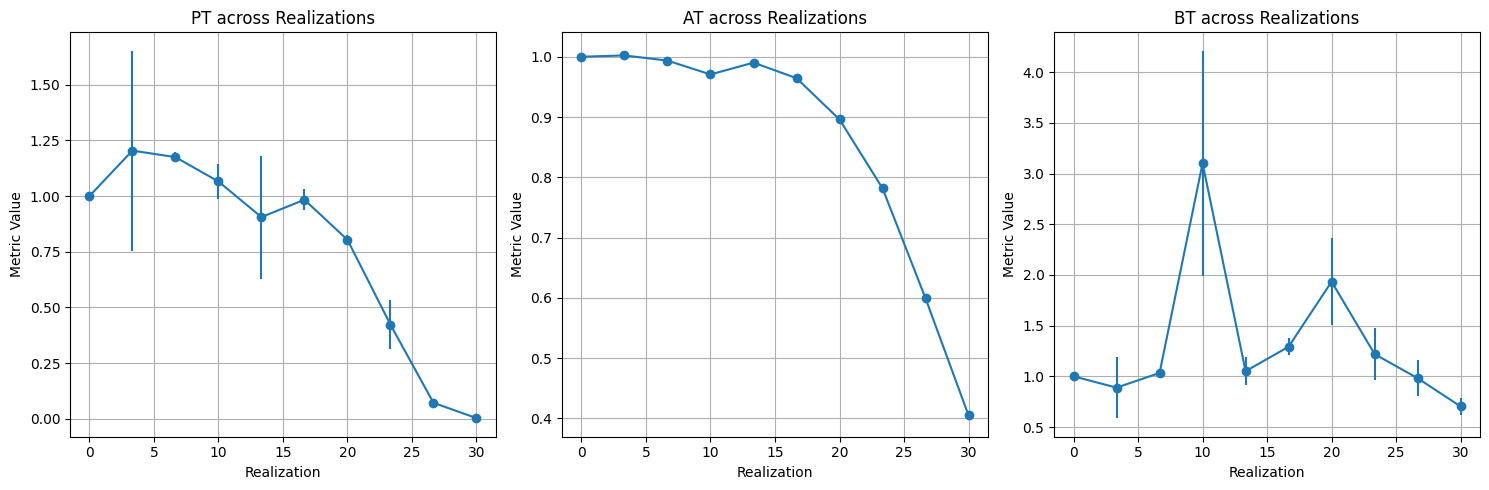

In [ ]:
# Plotting the statistics for each metric
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_statistics(pt_mean, pt_std, 'PT across Realizations')
plt.subplot(1, 3, 2)
plot_statistics(at_mean, at_std, 'AT across Realizations')
plt.subplot(1, 3, 3)
plot_statistics(bt_mean, bt_std, 'BT across Realizations')
plt.tight_layout()
plt.show()

Plotting dynamics biomarkers for each regions

In [ ]:
def compute_biomarkers(excitatory, inhibitory, dt, omega, node_groups, nperseg=None):
  fs = 1/dt
  z = excitatory + 1j * inhibitory
  results = {}

  # Compute global metrics
  global_avg_z = np.mean(z, axis=1)
  f, global_psd = welch(global_avg_z, fs=fs, nperseg=nperseg)
  global_interpolated_psd = np.interp(omega, f, global_psd)
  global_PT = np.trapz(global_interpolated_psd, omega)
  global_AT = np.mean(np.trapz(np.abs(z), dx=1/fs, axis=0))
  global_BT = np.mean(np.var(np.abs(z), axis=0))
  results['global'] = (global_PT, global_AT, global_BT)

  # Compute metrics per region
  for region, nodes in node_groups.items():
    region_z = np.mean(z[:, nodes], axis=1)
    f, region_psd = welch(region_z, fs=fs, nperseg=nperseg)
    region_interpolated_psd = np.interp(omega, f, region_psd)
    region_PT = np.trapz(region_interpolated_psd, omega)
    region_AT = np.mean(np.trapz(np.abs(z[:,nodes]), dx=1/fs, axis=0))
    region_BT = np.mean(np.var(np.abs(z[:, nodes]), axis=0))
    results[region] = (region_PT, region_AT, region_BT)

  return results

In [ ]:
def run_simulation(w_kj, realization_index, save_path, node_groups):
  # Initialize dictionaries to hold all region metrics including global dynamic biomarkers
  region_metrics = {region: {'pt':[], 'at':[], 'bt':[]} for region in node_groups}
  region_metrics['global'] = {'pt':[], 'at':[], 'bt':[]}

  # Loop through weight after each year of disease progression and simulate the resting state dynamics
  for w in tqdm(w_kj, desc=f"Realization:{realization_index}"):
    exc, inh, dt, times, omega = rsd_model(w)
    all_region_metrics = compute_biomarkers(exc, inh, dt, omega, node_groups)

    # Store metrics for 'global' and specified regions
    for region in all_region_metrics:
      region_metrics[region]['pt'].append(all_region_metrics[region][0])
      region_metrics[region]['at'].append(all_region_metrics[region][1])
      region_metrics[region]['bt'].append(all_region_metrics[region][2])

  # Save the biomarkers for all regions for the current realization
  for region in region_metrics:
    region_save_path = os.path.join(save_path, region)
    os.makedirs(region_save_path, exist_ok = True)
    np.save(os.path.join(region_save_path, f'dynamic_biomarkers_realization_v1_{realization_index}.npy'),
            np.array([region_metrics[region]['pt'], region_metrics[region]['at'], region_metrics[region]['bt']]))

  return region_metrics

In [ ]:
def scale_weights(w_kj_severe, xi):
    """
    Apply homeostasis adaptation to the weight matrix as per the provided formula.

    Parameters:
    w_kj_severe (numpy.ndarray): 3D array of shape (timepoints, nodes, nodes) representing the weight matrices over time.
    xi (float): Homeostasis parameter within [0, 1].

    Returns:
    numpy.ndarray: Scaled weights.
    """
    # Initialize the array for the scaled weights
    scaled_w_kj_severe = np.zeros_like(w_kj_severe)

    # Set the first timepoint to be the same as in w_kj_severe
    scaled_w_kj_severe[0] = w_kj_severe[0]

    # Apply scaling for each subsequent timepoint
    for T in range(1, len(w_kj_severe)):
        norm_W_T = np.linalg.norm(w_kj_severe[T])
        norm_W_T_minus_1 = np.linalg.norm(w_kj_severe[T - 1])
        scaled_w_kj_severe[T] = ((1 - xi) + xi * (norm_W_T_minus_1 / norm_W_T)) * w_kj_severe[T]

    return scaled_w_kj_severe


In [ ]:
node_groups = load_node_categories(mapping_filename)
all_region_metrics = {region: {'pt':[], 'at':[], 'bt':[]} for region in node_groups}
all_region_metrics['global'] = {'pt': [], 'at': [], 'bt': []}

number_of_realizations = 10

# Run simulation and save data
for realization_index in range(number_of_realizations):
    region_metrics = run_simulation(w_kj_severe, realization_index, 'gdrive/MyDrive/PBM-report2', node_groups)

    # Accumulate metrics across all realizations
    for region, metrics in region_metrics.items():
        for metric_type in ['pt', 'at', 'bt']:
            all_region_metrics[region][metric_type].extend(metrics[metric_type])

# # Load data, calculate statistics and plot
# metrics_all_realizations = {region: [] for region in node_groups.keys()}
# metrics_all_realizations['Global'] = []  # Include global if not already in node_groups

# for region in metrics_all_realizations.keys():
#     for realization_index in range(number_of_realizations):
#         data = np.load(f'path/to/save/dynamic_biomarkers_{region}_realization_{realization_index}.npy')
#         metrics_all_realizations[region].append(data)

# stats = calculate_statistics(metrics_all_realizations)
# plot_statistics(stats, ['PT', 'AT', 'BT'])

Realization:0:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
Realization:1:  30%|███       | 9/30 [15:59<37:18, 106.58s/it]


KeyboardInterrupt: 

In [ ]:
# for region, metrics in all_region_metrics.items():
#     stats[region] = {}
#     for metric_type in ['at']:
#         metric_data = np.array(metrics[metric_type]).reshape((number_of_realizations, len(transport_times)))
#         normalization_factor = metric_data[:,0]
#         print(region, metric_data, normalization_factor)
#         normalized_metric_data = metric_data / metric_data[:,0].reshape(-1,1)
#         print(normalized_metric_data)

In [ ]:
def calculate_statistics(all_region_metrics):
    stats = {}
    for region, metrics in all_region_metrics.items():
        stats[region] = {}
        for metric_type in ['pt', 'at', 'bt']:
            metric_data = np.array(metrics[metric_type]).reshape((number_of_realizations, len(transport_times)))
            normalized_metric_data = metric_data / metric_data[:,0].reshape(-1,1)
            mean = np.mean(normalized_metric_data, axis=0)
            std = np.std(normalized_metric_data, axis=0)
            stats[region][metric_type] = (mean, std)
    return stats

def plot_statistics(stats):
    # Define colors for each region specifically
    region_colors = {
        'basal_ganglia': 'violet',
        'limbic': 'darkblue',
        'temporal': 'skyblue',
        'occipital': 'green',
        'parietal': 'orange',
        'frontal': 'red',
        'global': 'black'
    }

    # Metric names to be plotted
    metric_names = ['PT', 'AT', 'BT']

    # Create a figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(9, 9), sharex=True)

    # Plot each metric in a separate subplot
    for i, metric in enumerate(metric_names):
        ax = axes[i]
        for region in stats.keys():
            mean, std = stats[region][metric.lower()]
            ax.errorbar(transport_times, mean, yerr=std, label=region if i == 1 else "_nolegend_",
                        color=region_colors.get(region), fmt='-o')
        ax.set_title(f'{metric} Across Realizations')
        ax.set_xlabel('Transport Times (s)')
        ax.set_ylabel(f'{metric} Value')
        ax.plot(transport_times, C_T_severe, alpha=0.2, linewidth=3.5, color='gray')

        # Only add legend to the AT plot
        if metric == 'AT':
            ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

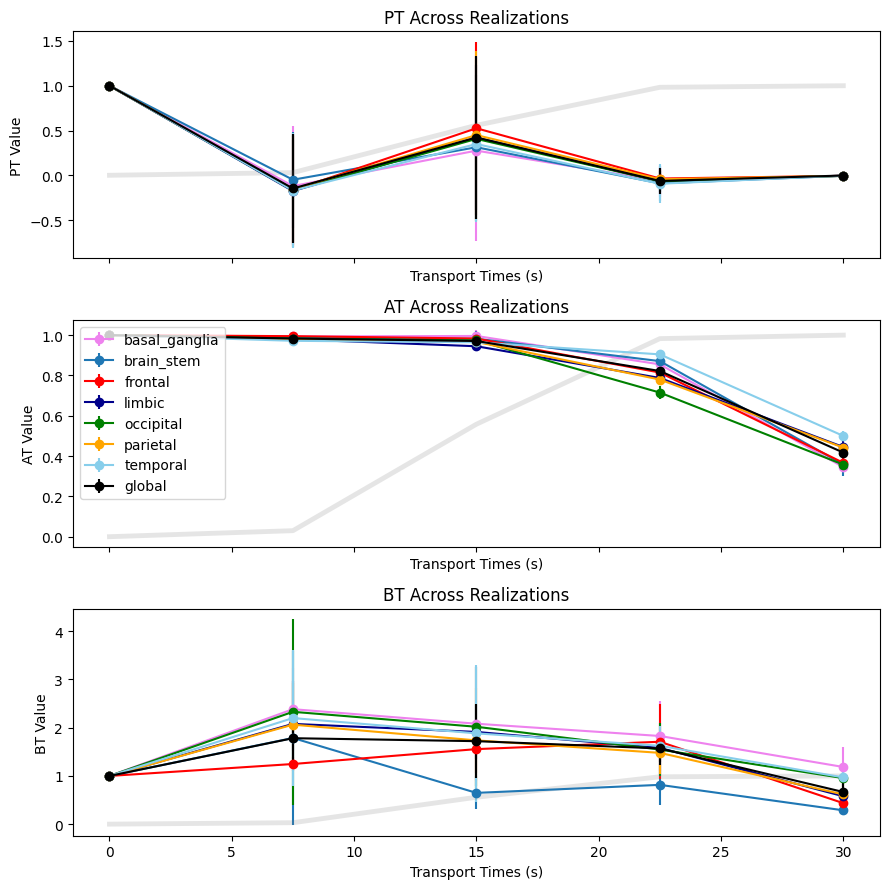

In [ ]:
# Calculate statistics
stats = calculate_statistics(all_region_metrics)

# Plot statistics
plot_statistics(stats)